/var/folders/6g/trn0tjkx2bx7vx6751ly6r500000gn/T/ipykernel_11996/1400313605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adaptations.dropna(subset=['time_gap'], inplace=True)


<Axes: xlabel='time_gap', ylabel='Count'>

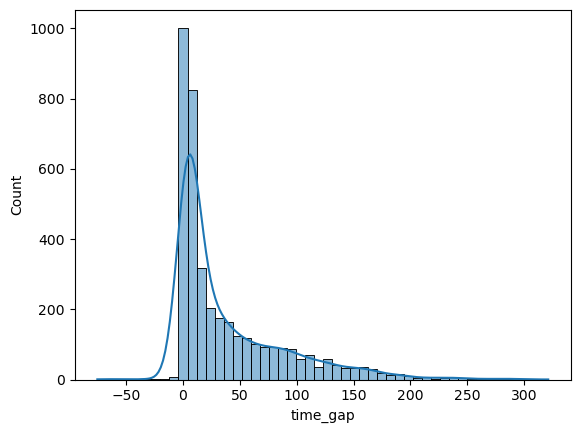

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/dataset_final.csv')

df_adaptations= df[df['movie_is_adaptation']==True]

df_adaptations.dropna(subset=['time_gap'], inplace=True)

sns.histplot(data=df_adaptations, x='time_gap', bins=50, kde=True)<

In [79]:
df_adaptations.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3890 entries, 40 to 76508
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            3890 non-null   int64  
 1   movie_title           3890 non-null   object 
 2   movie_release         3890 non-null   float64
 3   movie_revenue         1450 non-null   float64
 4   movie_runtime         3890 non-null   float64
 5   movie_languages       3890 non-null   object 
 6   movie_countries       3890 non-null   object 
 7   movie_genres          3890 non-null   object 
 8   movie_wikidata_id     3890 non-null   object 
 9   imdb_rating           3854 non-null   float64
 10  imdb_total_votes      3854 non-null   float64
 11  movie_budget          1191 non-null   float64
 12  book_wikidata_id      3890 non-null   object 
 13  book_title            3890 non-null   object 
 14  book_author           3868 non-null   object 
 15  book_release          38

In [43]:
#describe teh columns time gap, book rating, book pages, book ratings count, movie budget
df_adaptations[['time_gap', 'book_rating', 'book_pages', 'book_ratings_count', 'movie_budget']].describe()




,time_gap,book_rating,book_pages,book_ratings_count,movie_budget
count,3908.000000,2784.000000,3908.000000,2.785000e+03,1.192000e+03
mean,38.938843,3.889695,284.131013,1.689246e+05,1.206129e+07
std,50.101602,0.247686,163.782087,4.361091e+05,1.013057e+08
min,-75.000000,1.000000,1.000000,0.000000e+00,5.186864e-02
25%,4.000000,3.750000,216.000000,3.050000e+03,1.143553e+06
50%,15.000000,3.910000,260.000000,1.765500e+04,2.850653e+06
75%,59.000000,4.060000,320.000000,1.210890e+05,6.006203e+06
max,321.000000,4.620000,1720.000000,6.726008e+06,2.399138e+09


In [44]:
#drop rows where time gap is negative
df_adaptations = df_adaptations[df_adaptations['time_gap'] >= 0]


<Axes: xlabel='time_gap'>

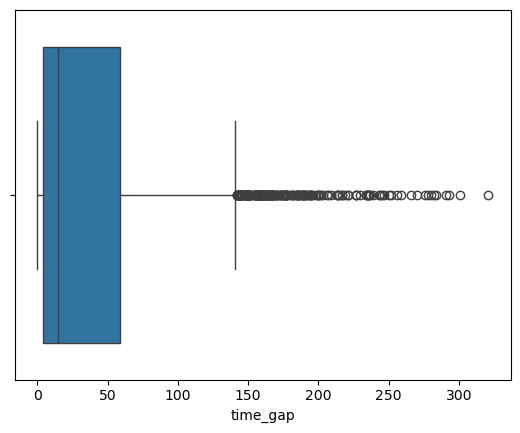

In [45]:
sns.boxplot(x=df_adaptations['time_gap'])

<Axes: xlabel='time_gap'>

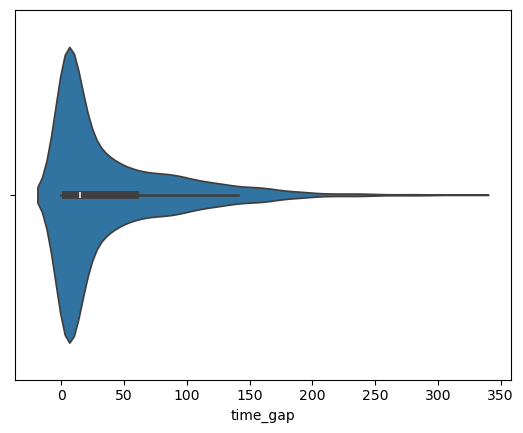

In [46]:
sns.violinplot(x=df_adaptations['time_gap'])

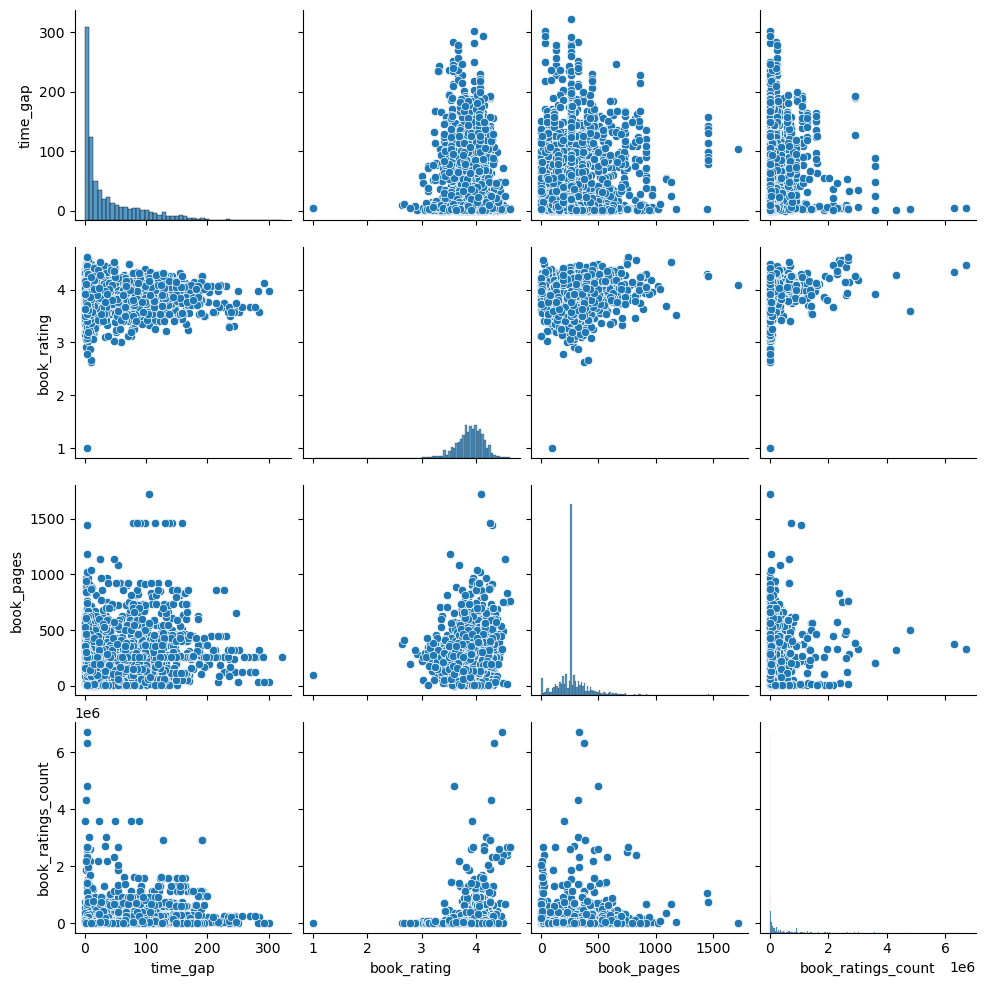

In [47]:
sns.pairplot(df_adaptations, vars=['time_gap', 'book_rating', 'book_pages', 'book_ratings_count'])


<Axes: >

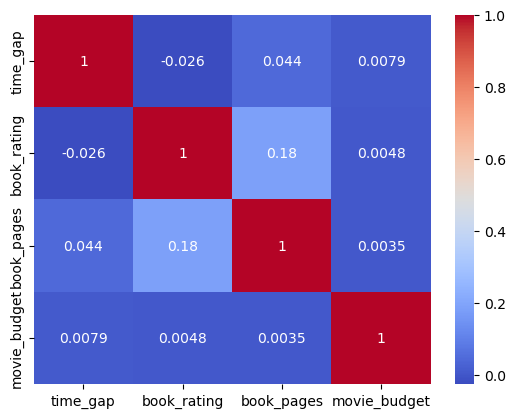

In [48]:
corr = df_adaptations[['time_gap', 'book_rating', 'book_pages', 'movie_budget']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [50]:
df_adaptations['log_time_gap'] = np.log1p(df_adaptations['time_gap'])




<Axes: xlabel='log_time_gap', ylabel='Count'>

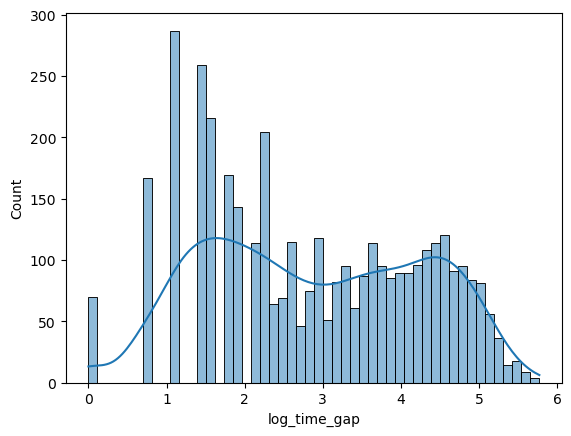

In [52]:
sns.histplot(x=df_adaptations['log_time_gap'], bins=50, kde=True)

In [54]:

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Prepare features and target
categorical_features = ['book_fiction', 'book_non_fiction', 'book_children', 
            'book_historical', 'book_drama', 'book_anime', 
            'book_fantasy', 'book_science_fiction', 'book_horror',
            'book_thriller', 'book_detective', 'book_satire', 
            'book_comedy', 'book_won_price']

numeric_features = ['book_rating', 'book_ratings_count', 'book_pages']

# Create X (features) and y (target)
X_cat = df_adaptations[categorical_features]
X_num = df_adaptations[numeric_features]

# Scale numeric features
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

# Combine categorical and scaled numeric features
X = pd.concat([X_cat, X_num_scaled], axis=1)
y = df_adaptations['log_time_gap']

# Drop rows with missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Add constant for statsmodels
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

# Print significant features (p < 0.05)
print("\nSignificant features (p < 0.05):")
significant_features = model.pvalues[model.pvalues < 0.05]
for feature, p_value in significant_features.items():
    coef = model.params[feature]
    print(f"{feature}: coefficient = {coef:.3f}, p-value = {p_value:.3f}")

                            OLS Regression Results                            
Dep. Variable:           log_time_gap   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     19.66
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.85e-57
Time:                        21:00:18   Log-Likelihood:                -4696.3
No. Observations:                2775   AIC:                             9429.
Df Residuals:                    2757   BIC:                             9535.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.7212 

In [80]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
X = df_adaptations[features + ['book_rating', 'book_ratings_count', 'book_pages']]
y = df_adaptations['log_time_gap']
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
lasso = Lasso(alpha=0.01, random_state=42)
ridge = Ridge(alpha=1.0)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train and predict
models = {'Lasso': lasso, 'Ridge': ridge, 'Random Forest': random_forest}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

results

lasso_weights = dict(zip(X_train.columns, lasso.coef_))
ridge_weights = dict(zip(X_train.columns, ridge.coef_))

# Get Random Forest feature importances
rf_importances = dict(zip(X_train.columns, random_forest.feature_importances_))

# Combine all weights into a structured output
weights_summary = {
    'Lasso Coefficients': lasso_weights,
    'Ridge Coefficients': ridge_weights,
    'Random Forest Importances': rf_importances
}

weights_summary

{'Lasso Coefficients': {'book_fiction': 0.4495937734396104,
  'book_non_fiction': -0.004237131031225693,
  'book_children': 0.1278122165860994,
  'book_historical': 0.36400643619481804,
  'book_drama': 0.6576599169048746,
  'book_anime': -0.0,
  'book_fantasy': 0.08188452893986067,
  'book_science_fiction': 0.0,
  'book_horror': -0.19493210453095633,
  'book_thriller': -1.0036685137413546,
  'book_detective': -0.0,
  'book_satire': 0.3912271793385806,
  'book_comedy': -0.0,
  'book_won_price': -0.1137476430358176,
  'book_rating': -0.10117406726591127,
  'book_ratings_count': 2.316976944824165e-07,
  'book_pages': -4.871452511614736e-05},
 'Ridge Coefficients': {'book_fiction': 0.6113231212342658,
  'book_non_fiction': -0.2680104347481543,
  'book_children': 0.3137099557279809,
  'book_historical': 0.4673099232925744,
  'book_drama': 1.0479758103977794,
  'book_anime': -0.5768387777905568,
  'book_fantasy': 0.13602772177256592,
  'book_science_fiction': 0.02136786610599379,
  'book_hor

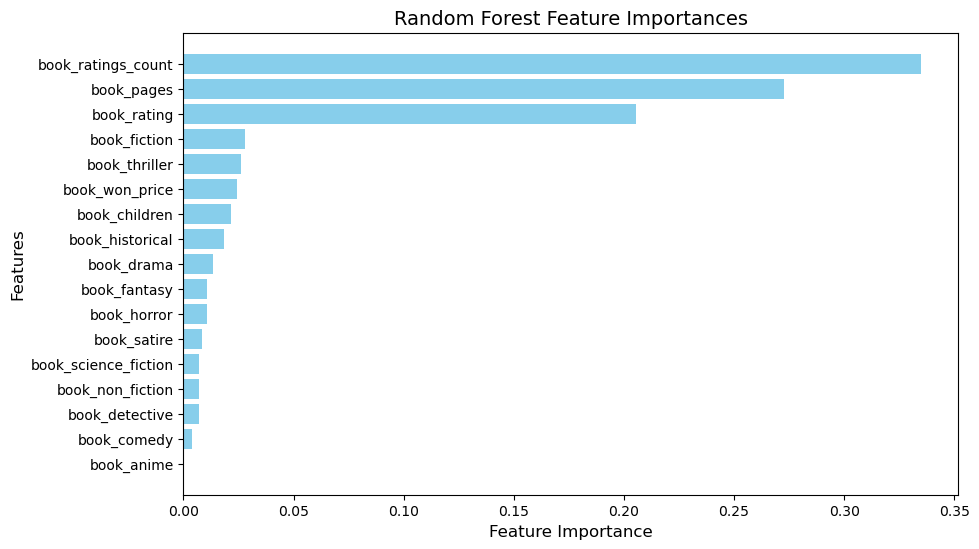

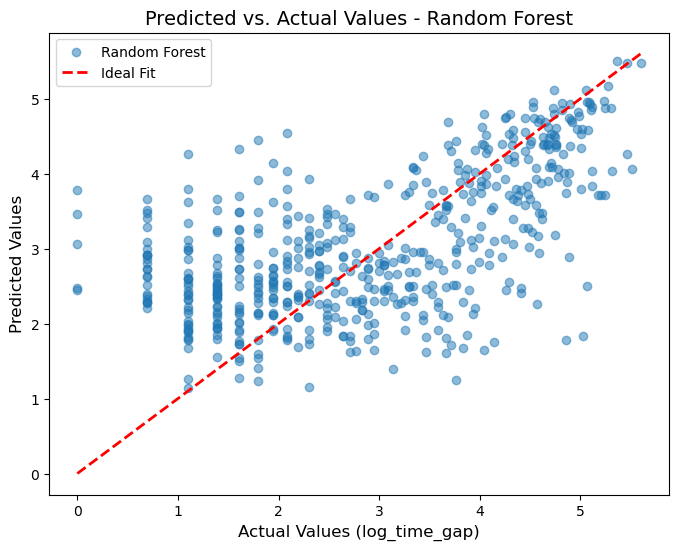

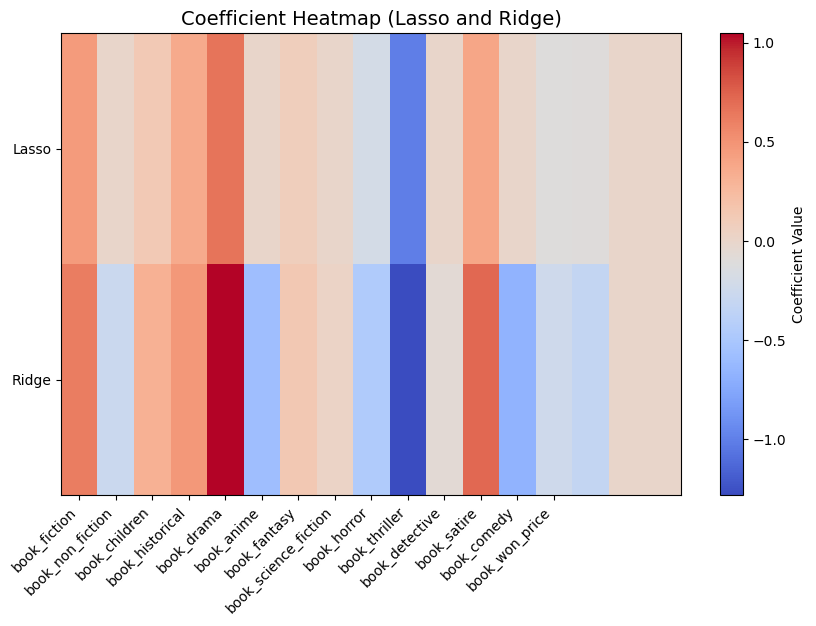

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Feature Importance Bar Plot (Random Forest)
rf_importances_sorted = sorted(rf_importances.items(), key=lambda x: x[1], reverse=True)
features_rf, importances_rf = zip(*rf_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(features_rf, importances_rf, color="skyblue")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Random Forest Feature Importances", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

# 2. Predicted vs. Actual Values for Random Forest
y_pred_rf = random_forest.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="Ideal Fit")
plt.xlabel("Actual Values (log_time_gap)", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title("Predicted vs. Actual Values - Random Forest", fontsize=14)
plt.legend()
plt.show()

# 3. Coefficient Heatmap (Lasso and Ridge)
lasso_coefs = np.array(list(lasso_weights.values()))
ridge_coefs = np.array(list(ridge_weights.values()))

coef_data = np.vstack([lasso_coefs, ridge_coefs])
coef_labels = ["Lasso", "Ridge"]

plt.figure(figsize=(10, 6))
plt.imshow(coef_data, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Coefficient Value")
plt.xticks(ticks=np.arange(len(features)), labels=features, rotation=45, ha="right")
plt.yticks(ticks=[0, 1], labels=coef_labels)
plt.title("Coefficient Heatmap (Lasso and Ridge)", fontsize=14)
plt.show()


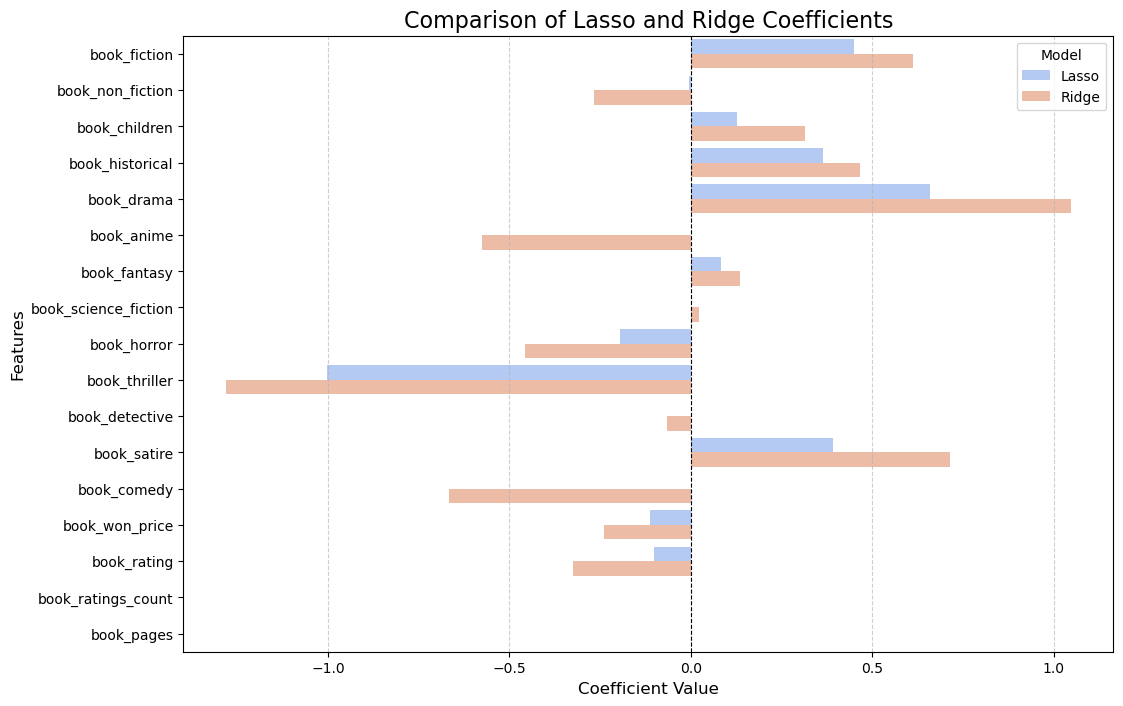

In [61]:
import seaborn as sns

# Prepare data for Lasso and Ridge coefficients
coefficients_df = pd.DataFrame({
    "Feature": list(lasso_weights.keys()),
    "Lasso": list(lasso_weights.values()),
    "Ridge": list(ridge_weights.values())
})

# Melt the dataframe for easier plotting
coefficients_melted = coefficients_df.melt(id_vars="Feature", var_name="Model", value_name="Coefficient")

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=coefficients_melted,
    x="Coefficient",
    y="Feature",
    hue="Model",
    palette="coolwarm"
)
plt.title("Comparison of Lasso and Ridge Coefficients", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.legend(title="Model", fontsize=10)
plt.axvline(0, color="black", linewidth=0.8, linestyle="--")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


In [95]:
df_adaptations[df_adaptations['book_fiction']==True][['time_gap','book_won_price', 'book_title', 'movie_title', 'movie_budget', 'movie_revenue', 'movie_runtime']].sort_values('movie_revenue', ascending=False).head(20)

,time_gap,book_won_price,book_title,movie_title,movie_budget,movie_revenue,movie_runtime
25240,32.0,1.0,Red Harvest,Yojimbo,7.085316e+08,2.736817e+09,110.0
22221,2.0,0.0,The Exorcist,The Exorcist,8.591956e+06,4.737078e+08,120.0
68643,99.0,0.0,War and Peace,War and Peace,1.818986e+08,3.821726e+08,401.0
72733,1.0,0.0,Jaws,Jaws,5.209524e+06,3.502683e+08,130.0
20960,17.0,0.0,The Sentinel,2001: A Space Odyssey,1.909935e+07,3.456073e+08,156.0
29940,5.0,0.0,Ice Station Zebra,Ice Station Zebra,5.930265e+07,3.414133e+08,122.0
34193,3.0,0.0,The Godfather,The Godfather,7.614816e+06,3.407630e+08,177.0
10389,5.0,0.0,The Godfather,The Godfather Part II,1.106355e+07,1.642512e+08,200.0
55334,4.0,0.0,Dr. No,Dr. No,2.356473e+06,1.478377e+08,109.0
8604,2.0,0.0,Airport,Airport,1.447171e+07,1.454250e+08,137.0


Books classified as fiction, historical, children’s, and drama genres tend to have the longest adaptation time gaps. This is likely due to the demanding production requirements, such as the need to create entirely new worlds, characters, and elaborate settings.

Satire books also show a tendency for delayed adaptations. This delay could be attributed to censorship challenges, as satire often addresses sensitive societal topics that may not always align with mainstream readiness or acceptance.

On the other hand, thriller and horror books exhibit the shortest adaptation gaps. This is likely because these genres are highly popular and in greater demand, making production companies more inclined to adapt them quickly. Additionally, their value lies more in execution—such as the ambiance, music, and plot—rather than requiring high budgets or complex production.

As for anime books, their impact on adaptation time gaps is insignificant due to their limited representation in the dataset.

Finally, book rating count and award-winning status—both proxies for a book’s popularity—negatively impact the adaptation time gap, particularly rating count. This result is expected, as popular books are more likely to attract faster adaptations, reducing the time gap significantly.

JAWs for thriler
The tin drum satire
The Great Gatsby drama 
horror The Exorcist	
book won price The Polar Express	
fiction Around the World in Eighty Days



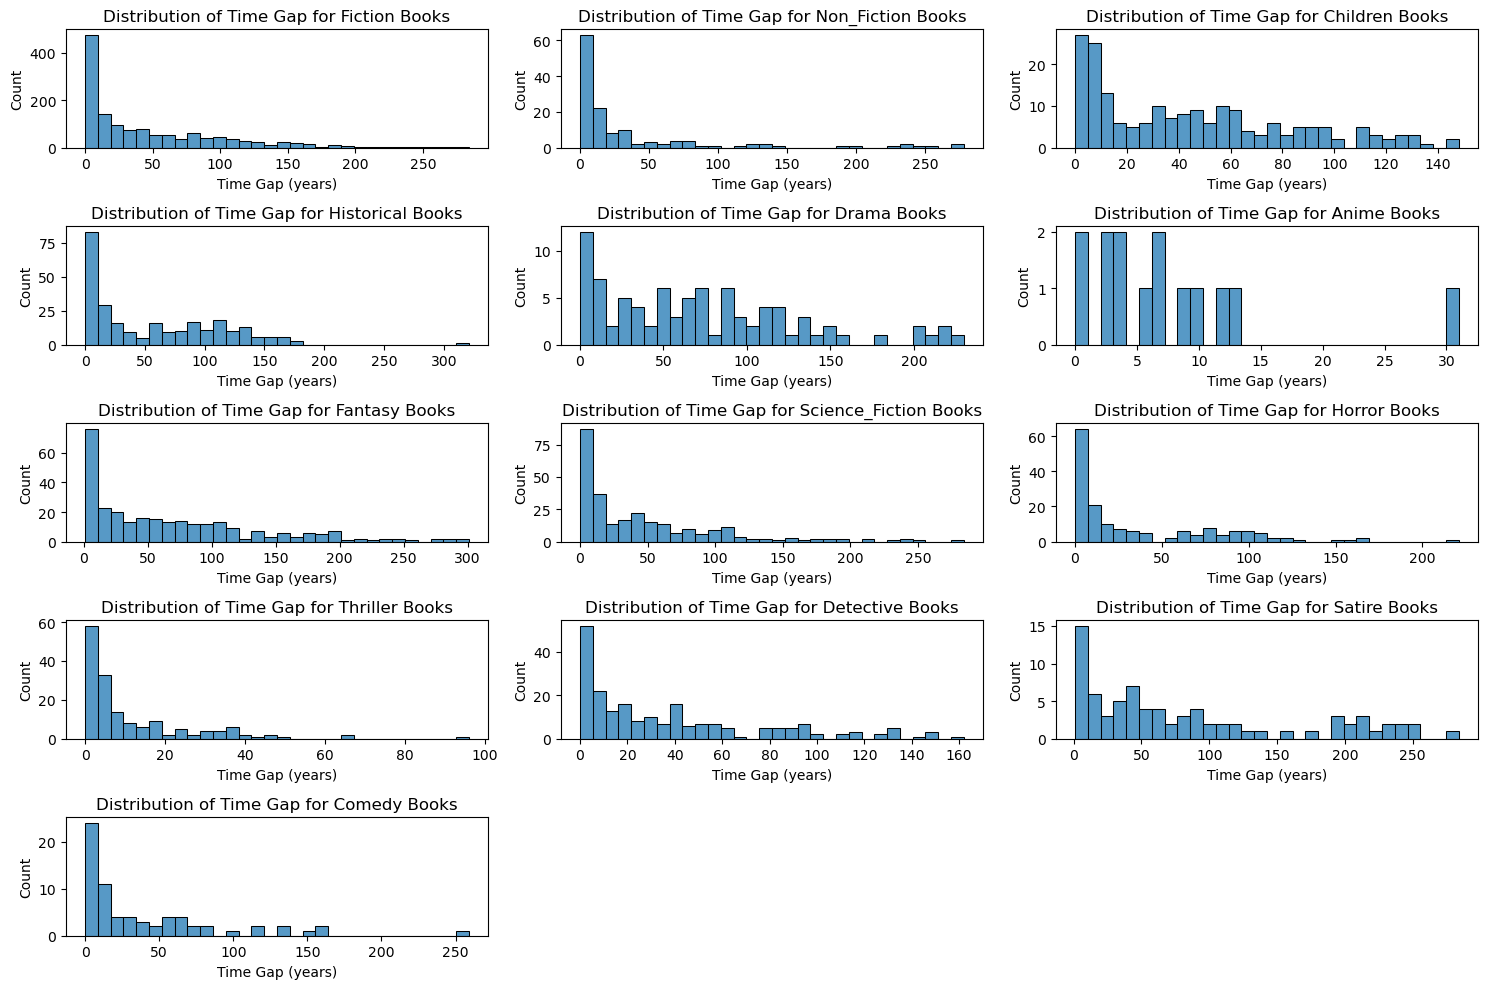

/var/folders/6g/trn0tjkx2bx7vx6751ly6r500000gn/T/ipykernel_11996/1319310978.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(genre_data, labels=[g.replace("book_", "").title() for g in genres])


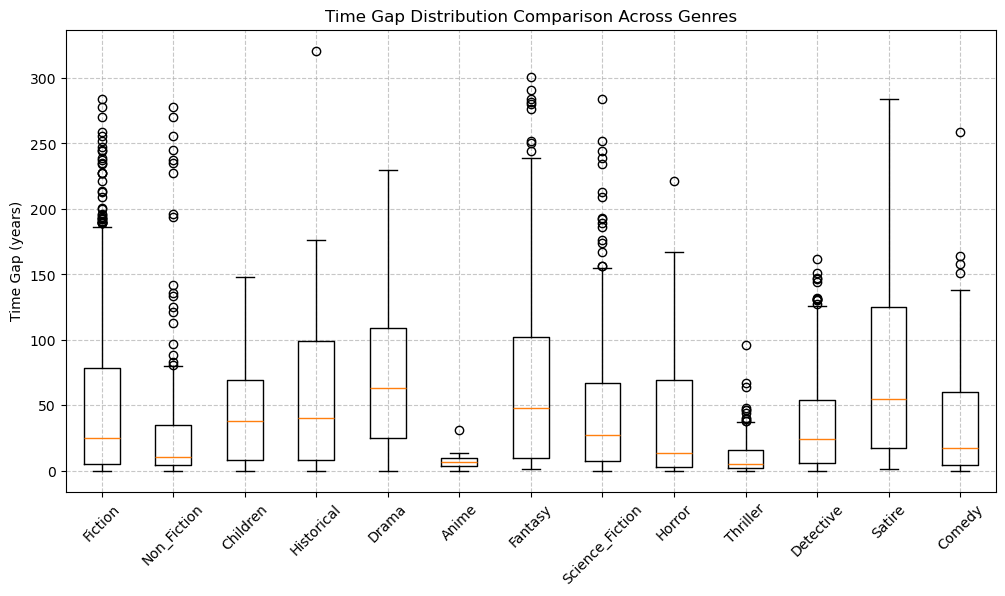

In [101]:


# Create a figure with subplots for each genre
plt.figure(figsize=(15, 10))

# List of genres to plot
genres = ['book_fiction', 'book_non_fiction', 'book_children', 
            'book_historical', 'book_drama', 'book_anime', 
            'book_fantasy', 'book_science_fiction', 'book_horror',
            'book_thriller', 'book_detective', 'book_satire', 
            'book_comedy']

# Create subplot for each genre
for i, genre in enumerate(genres, 1):
    plt.subplot(5, 3, i)
    
    # Plot distribution of time_gap for books in this genre
    sns.histplot(data=df_adaptations[df_adaptations[genre]==True], x='time_gap', bins=30)
    
    # Add title and labels
    plt.title(f'Distribution of Time Gap for {genre.replace("book_", "").title()} Books')
    plt.xlabel('Time Gap (years)')
    plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Also create a box plot to compare distributions
plt.figure(figsize=(12, 6))
genre_data = []
genre_labels = []

for genre in genres:
    genre_data.append(df_adaptations[df_adaptations[genre]==True]['time_gap'])
    genre_labels.extend([genre.replace("book_", "").title()] * len(df_adaptations[df_adaptations[genre]==True]))

plt.boxplot(genre_data, labels=[g.replace("book_", "").title() for g in genres])
plt.title('Time Gap Distribution Comparison Across Genres')
plt.ylabel('Time Gap (years)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
